# Effect of drugs on the information from viral PPIs

**Computes the change in network relative entropy from viral PPIs after setting drug state to high abundance**

In [1]:
import os, sys
import numpy as np
import scipy as sp
import pandas as pd
import copy as copy
from tqdm.notebook import tqdm
import math
import scipy.stats as st

from CoRe import reader
from CoRe.ncip import ncip
from CoRe.BA_C import BA

import importlib

import networkx as nx
import matplotlib.pyplot as plt
import json

from matplotlib import cm
from matplotlib import rcParams
import matplotlib.patches as patches

In [2]:
data_directory = "./Examples/Immune_System"
os.chdir(data_directory)

edge_data = pd.read_pickle('Immune_System_medium-PPI-edges.pkl')
node_data = pd.read_pickle('Immune_System_medium-PPI-nodes.pkl')

In [3]:
remake_graph = False

if remake_graph==False:
    netObj = ncip()
    netObj.load_graph('Immune_System-medium-PPI.gml')
else:
    netObj = ncip()
    netObj.load_data(edge_data,node_data)
    netObj.make_graph()
    netObj.save_network(pathway_nametag,network_type)

**Drugs that are part of the immune system in the Reactome database**

In [4]:
drugs = []
drug_names = []

all_nodes = netObj.G_d.nodes(data=True)

for n in netObj.G_d.nodes(data=True):
    if 'Drug' in n[1]['class'] and 'lat' not in n[1]['name'] and n[0] not in drug_names:
        print(n[0],n[1]['name'],n[1]['class'])
        drugs.append((n[0],n[1]['class'],n[1]['name']))
        drug_names.append(n[0])

R-ALL-9679737 natalizumab [extracellular region] ProteinDrug
R-ALL-9681784 anakinra [extracellular region] ProteinDrug
R-ALL-9681764 isunakinra [extracellular region] ProteinDrug
R-ALL-9678829 baricitinib [cytosol] ChemicalDrug
R-ALL-9678779 tofacitinib [cytosol] ChemicalDrug
R-ALL-9678901 ibrutinib [cytosol] ChemicalDrug
R-ALL-9678960 acalabrutinib [cytosol] ChemicalDrug
R-ALL-9678786 ruxolitinib [cytosol] ChemicalDrug
R-ALL-9715049 sarilumab [extracellular region] ProteinDrug
R-ALL-9715070 satralizumab [extracellular region] ProteinDrug
R-ALL-9681301 tocilizumab [extracellular region] ProteinDrug
R-ALL-9679801 amlexanox [cytosol] ChemicalDrug
R-ALL-9724689 omalizumab [extracellular region] ProteinDrug
R-ALL-9678991 tacrolimus [cytosol] ChemicalDrug
R-ALL-9679471 camrelizumab [extracellular region] ProteinDrug
R-ALL-9679434 cemiplimab [extracellular region] ProteinDrug
R-ALL-9679411 nivolumab [extracellular region] ProteinDrug
R-ALL-9678628 HCQ [cytosol] ChemicalDrug
R-ALL-9717004 del

**All immune system communication network proteins that have PPI with SARS-CoV-2 proteins**

In [5]:
f = open('SARS_CoV2-Immune_System_interactions.json')
SARS_nodes = json.load(f)
f.close()

all_sars_nodes = []

for s in SARS_nodes.keys():
    all_sars_nodes += SARS_nodes[s]
    
all_sars_nodes = list(set(all_sars_nodes))

print(all_sars_nodes)

['RAB18', 'HMOX1', 'SLC44A2', 'TBK1', 'HECTD1', 'ITGB1', 'RAB5C', 'GOLGA7', 'STOM', 'NLRX1', 'PTGES2', 'GGH', 'CYB5R3', 'ELOB', 'RAB7A', 'RHOA', 'IMPDH2', 'EIF4E2', 'PVR', 'CSNK2B', 'ANO6', 'ELOC', 'RAB10', 'SLC27A2', 'RALA', 'GLA', 'ECSIT', 'RIPK1', 'AP2A2', 'RNF41', 'NPC2', 'ERP44', 'NEU1', 'RAB14', 'IL17RA', 'TOMM70']


**Specifying the reference state and construction of the global transition matrix**

In [6]:
initial_state_type = 'maxEnt'

errorname = '0.0'
rho = float(errorname)

input_bits = 1
code_length = int(2**input_bits)

max_entropy_state = (1.0/float(code_length))*np.ones(shape=(code_length,))

low_state = np.zeros(shape=(code_length,))
low_state[-1] = 1.0

high_state = np.zeros(shape=(code_length,))
high_state[0] = 1.0

if initial_state_type=='high':
    initial_state = high_state
elif initial_state_type=='low':
    initial_state = low_state
else:
    initial_state = max_entropy_state

print(high_state,low_state)

netObj.construct_C(rho,h=input_bits,neglect_modules=[])
node_list = list(netObj.G_d.nodes)

[1. 0.] [0. 1.]


**Disconnect all drugs from the network initially**

In [7]:
netObj.disconnect_drug_nodes()

**Compute the reference stationary state of the network**

In [8]:
initial_network_state = np.zeros(shape=(netObj.C_sparse.shape[0],1))
network_sources = {}

for n in range(0,len(node_list)):
    initial_network_state[code_length*n:code_length*(n+1),0] = initial_state
    
network_sources = []

reference_final_state, steps = netObj.get_final_state(initial_network_state,[])
reference_final_entropy = netObj.state_entropy(reference_final_state,[])
print('Reference state relative entropy: ',reference_final_entropy)

Reference state relative entropy:  0.0


**Set the SARS-CoV-2 nodes in the network to low abundance**

In [9]:
network_state = np.zeros(shape=(netObj.C_sparse.shape[0],1))
network_sources = []

for n in range(0,len(node_list)):
    network_state[code_length*n:code_length*(n+1),0] = initial_state

for k in tqdm(SARS_nodes.keys()):
    for n in SARS_nodes[k]:
        try:
            i = node_list.index(n)

            network_state[netObj.code_length*i:netObj.code_length*(i+1),0] = low_state

            if i not in network_sources:
                network_sources.append(i)
        except ValueError:
            pass

  0%|          | 0/17 [00:00<?, ?it/s]

**Compute stationary state of the network due to SARS-CoV-2 PPIs**

In [10]:
final_state, steps = netObj.get_final_state(network_state,network_sources)
SARSCoV2_entropy = netObj.state_entropy(final_state,network_sources,reference_final_state)

**Compute stationary state of the network due to SARS-CoV-2 PPIs and drugs**

The drugs in the Reactome database were set to the state {1,0} to compute the stationary state, and the subsequent change in the network relative entropy.

In [11]:
df_H_with_drugs = pd.DataFrame()
df_H_drop_and_gain = pd.DataFrame()

df_H_with_drugs = pd.DataFrame([],columns=['Drug','Relative Entropy','Drug Type'])

df_H_drop_and_gain = pd.DataFrame([],columns=['Drug','Drop', 'Gain','Drug Type'])

In [12]:
for this_drug in tqdm(drugs):
    s = this_drug[0]
    additional_source_nodes = [s]
    
    netObj.load_graph('Immune_System-medium-PPI.gml')
    netObj.disconnect_drug_nodes(skip=s)
    
    netObj.construct_C(rho,h=input_bits)
    
    network_state = np.zeros(shape=(netObj.C_sparse.shape[0],1))
    network_sources = []
    
    for n in range(0,len(node_list)):
        network_state[code_length*n:code_length*(n+1),0] = initial_state

    for k in SARS_nodes.keys():
        for n in SARS_nodes[k]:
            try:
                i = node_list.index(n)

                network_state[netObj.code_length*i:netObj.code_length*(i+1),0] = low_state

                network_sources.append(i)
            except ValueError:
                pass

        for n in additional_source_nodes:
            try:
                i = node_list.index(n)

                network_state[netObj.code_length*i:netObj.code_length*(i+1),0] = high_state

                network_sources.append(i)
            except ValueError:
                pass
        
    this_state, steps = netObj.get_final_state(network_state,network_sources)
    H_with_drugs = netObj.state_entropy(this_state,network_sources,reference_final_state)
    H_drop, H_gain = netObj.entropy_drop_and_rise(this_state,final_state,reference_final_state,network_sources)
    
    drug_name = this_drug[2].split(' [')[0]
    
    df_temp = pd.DataFrame([[drug_name,H_with_drugs,this_drug[1]]],columns=['Drug','Relative Entropy','Drug Type'])
    df_H_with_drugs = pd.concat([df_H_with_drugs,df_temp],sort=False,ignore_index=True)

    df_temp = pd.DataFrame([[drug_name,H_drop,H_gain,this_drug[1]]],columns=['Drug', 'Drop', 'Gain','Drug Type'])
    df_H_drop_and_gain = pd.concat([df_H_drop_and_gain,df_temp],sort=False,ignore_index=True)

  0%|          | 0/19 [00:00<?, ?it/s]

In [13]:
try:
    os.chdir('./counter_entropic_shift')
except OSError:
    os.mkdir('./counter_entropic_shift')
    os.chdir('./counter_entropic_shift')

In [14]:
df_H_with_drugs = df_H_with_drugs.sort_values(by=['Relative Entropy'],ignore_index=True)

all_tick_names = df_H_with_drugs['Drug'].to_list()
tick_names = [n.split(' [')[0] for n in all_tick_names]
data_size = len(tick_names)
x = np.linspace(1,data_size,data_size)

In [15]:
df_temp = pd.DataFrame([['Ref',SARSCoV2_entropy,'None']],columns=['Protein','Relative Entropy','Drug Type'])
df_H_with_drugs = pd.concat([df_temp,df_H_with_drugs],sort=False,ignore_index=True)

df_H_with_drugs.to_csv('high_all_drug_shifts-'+initial_state_type+'.csv',index=False)

df_H_drop_and_gain = df_H_drop_and_gain.sort_values(by=['Drop'],ascending=False,ignore_index=True)
df_H_drop_and_gain.to_csv('split_all_drug_shifts-'+initial_state_type+'.csv',index=False)

**Setup colorbar scale**

In [16]:
c_high = df_H_with_drugs['Relative Entropy'].to_numpy()[1:] - SARSCoV2_entropy
r_min, r_max = np.min(c_high), np.max(c_high)
max_r = max(abs(r_min),abs(r_max))
v_min, v_max = -abs(r_min), abs(r_min)

**Plot drugs ranked by their $ \Delta H_{\mathrm{ref}}(X) $**

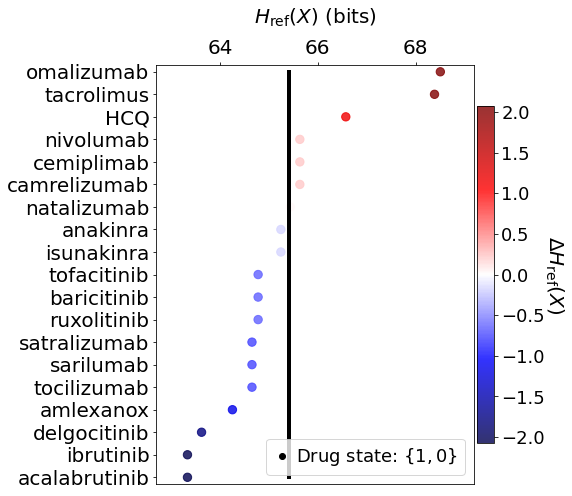

In [19]:
fig, ax = plt.subplots(figsize=(8,7))

plt.scatter(df_H_with_drugs['Relative Entropy'].to_numpy()[1:],x,c=c_high,cmap=cm.seismic,vmin=v_min,vmax=v_max,marker='o',alpha=0.8,s=70)
plt.plot(SARSCoV2_entropy*np.ones(shape=x.shape),x,color='black',markersize=0,linewidth=4,alpha=1.0)
plt.ylim(0.7,data_size+0.3)

ax.set_yticks(np.arange(1,data_size+1))
ax.set_yticklabels(tick_names,fontsize=14,rotation=0)

plt.xlabel(r'$H_{\mathrm{ref}}(X)$ (bits)',size=20,labelpad=15)
plt.tick_params(axis='both',labelsize=20)

ax.xaxis.tick_top()
ax.xaxis.set_label_position('top') 

plt.xlim(0.99*np.min(df_H_with_drugs['Relative Entropy']),1.01*np.max(df_H_with_drugs['Relative Entropy']))

plt.plot(-10,SARSCoV2_entropy,lw=0,ms=6,marker='o',label=r'Drug state: $\{1,0\}$',c='black')

plt.legend(loc='lower right',frameon=True,fontsize=18,handlelength=1.0,handletextpad=0.25)

cbar = plt.colorbar(fraction=0.05,pad=0.01)

cbar.set_label(r'$\Delta H_{\mathrm{ref}}(X)$',fontsize=20,rotation=-90,labelpad=20)
cbar.ax.tick_params(labelsize=18)

plt.tight_layout()

plt.show()

**Plot drugs ranked by their $ \Delta H_{\mathrm{ref}}(X) $ drop component**

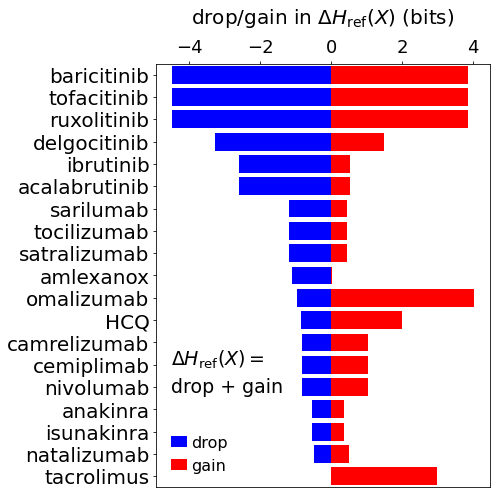

In [20]:
fig, ax = plt.subplots(figsize=(7,7))

plt.barh(x,df_H_drop_and_gain['Drop'],color='Blue',label='drop')
plt.barh(x,df_H_drop_and_gain['Gain'],color='Red',label='gain')

plt.xlabel(r'drop/gain in $\Delta H_{\mathrm{ref}}(X)$ (bits)',size=20,labelpad=15)

plt.tick_params(axis='x',labelsize=20,rotation=0)
plt.tick_params(axis='y',labelsize=20)

plt.ylim(0.5,len(df_H_drop_and_gain['Drug'])+0.5)
plt.tick_params(axis='x',labelsize=18)
plt.legend(frameon=False,fontsize=16,handlelength=1.0,handletextpad=0.25)
plt.text(-4.5,6,r'$\Delta H_{\mathrm{ref}}(X)=$',fontsize=19)
plt.text(-4.5,4.75,r'drop + gain',fontsize=19)

ax.xaxis.tick_top()
ax.xaxis.set_label_position('top') 

ax.set_yticks(np.arange(1,data_size+1))
ax.set_yticklabels(df_H_drop_and_gain['Drug'],fontsize=20,rotation=0)

plt.tight_layout()

plt.show()